In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Download NLTK resources
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f"Using device: {device}")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/gerald/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/gerald/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gerald/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-03-24 01:54:43,503 - INFO - Using device: cpu


In [2]:
def read_csv_with_fallback(filepath, encoding='utf-8', sep=',', engine='python', on_bad_lines='skip'):
    """
    Read a CSV file with multiple fallback options for handling errors.
    """
    try:
        # Try reading with the most common parameters
        df = pd.read_csv(filepath, encoding=encoding, sep=sep, engine=engine, on_bad_lines=on_bad_lines)
    except pd.errors.ParserError:
        try:
            # Fallback to older parameter name for on_bad_lines
            df = pd.read_csv(filepath, encoding=encoding, sep=sep, engine=engine, error_bad_lines=False)
        except Exception as e:
            # Final fallback with additional parameters
            logging.warning(f"Failed to read CSV with standard parameters. Trying with additional options: {e}")
            df = pd.read_csv(filepath, encoding=encoding, sep=sep, engine=engine, quoting=3, escapechar='\\')
    return df

def rename_and_merge(disney_df, uss_df):
    """
    Rename columns and merge Disney and Universal Studios datasets.
    """
    # Rename Disney columns
    disney_renamed = disney_df.rename(columns={
        'Review_ID': 'review_id',
        'Rating': 'rating',
        'Year_Month': 'date',
        'Reviewer_Location': 'reviewer_location',
        'Review_Text': 'review_text',
        'Branch': 'branch'
    })

    # Rename Universal Studios columns
    uss_renamed = uss_df.rename(columns={
        'reviewer': 'reviewer_name',  # Assuming 'reviewer' is the reviewer's name
        'written_date': 'date',
        'title': 'review_title',
        'review_text': 'review_text'
    })

    # Add park type labels
    disney_renamed['park_type'] = 'Disney'
    uss_renamed['park_type'] = 'USS'

    # Add missing columns if necessary
    if 'review_id' not in uss_renamed.columns:
        uss_renamed['review_id'] = uss_renamed.index + len(disney_renamed)
    if 'review_title' not in disney_renamed.columns:
        disney_renamed['review_title'] = np.nan

    # Select common columns
    common_columns = [
        'review_id', 'rating', 'date', 'reviewer_location', 'reviewer_name',
        'review_text', 'review_title', 'branch', 'park_type'
    ]

    # Ensure both datasets have the required columns
    if 'reviewer_location' not in uss_renamed.columns:
        uss_renamed['reviewer_location'] = np.nan  # Add missing location column
    if 'reviewer_name' not in disney_renamed.columns:
        disney_renamed['reviewer_name'] = np.nan  # Add missing name column

    disney_common = disney_renamed[common_columns]
    uss_common = uss_renamed[common_columns]

    # Merge datasets
    combined_df = pd.concat([disney_common, uss_common], ignore_index=True)
    return combined_df

def preprocess_data(combined_df):
    """
    Preprocess the merged dataset:
    - Standardize the 'date' column.
    - Extract 'year' and 'month'.
    - Handle missing values.
    - Create 'bad_experience' label.
    """
    # Standardize the 'date' column
    combined_df['date'] = pd.to_datetime(combined_df['date'], errors='coerce')

    # Extract 'year' and 'month'
    combined_df['year'] = combined_df['date'].dt.year
    combined_df['month'] = combined_df['date'].dt.month

    # Handle missing values
    combined_df['review_title'] = combined_df['review_title'].fillna('No Title')
    combined_df = combined_df.dropna(subset=['review_text'])

    # Convert 'rating' to numeric
    combined_df['rating'] = pd.to_numeric(combined_df['rating'], errors='coerce')

    # Create 'bad_experience' label (rating <= 4 is negative experience)
    combined_df['bad_experience'] = (combined_df['rating'] <= 4).astype(int)

    return combined_df

In [3]:
# File paths
disney_filepath = 'data/DisneylandReviews.csv'
uss_filepath = 'data/universal_studio_branches.csv'

# Read Disney data
disney_df = pd.read_csv(disney_filepath, encoding='utf-8', encoding_errors='replace')
logging.info(f"Successfully read Disneyland data, {len(disney_df)} rows")

# Read Universal Studios data with fallback options
uss_df = read_csv_with_fallback(uss_filepath)
logging.info(f"Successfully read Universal Studios data, {len(uss_df)} rows")

# Rename and merge datasets
combined_df = rename_and_merge(disney_df, uss_df)

# Preprocess the merged dataset
combined_df = preprocess_data(combined_df)

# Display the first few rows of the merged dataset
combined_df.head()

2025-03-24 01:54:43,703 - INFO - Successfully read Disneyland data, 42656 rows
2025-03-24 01:54:43,950 - INFO - Successfully read Universal Studios data, 50904 rows


,review_id,rating,date,reviewer_location,reviewer_name,review_text,review_title,branch,park_type,year,month,bad_experience
0,670772142,4.0,2019-04-01,Australia,NaN,If you've ever been to Disneyland anywhere you...,No Title,Disneyland_HongKong,Disney,2019.0,4.0,1
1,670682799,4.0,2019-05-01,Philippines,NaN,Its been a while since d last time we visit HK...,No Title,Disneyland_HongKong,Disney,2019.0,5.0,1
2,670623270,4.0,2019-04-01,United Arab Emirates,NaN,Thanks God it wasn t too hot or too humid wh...,No Title,Disneyland_HongKong,Disney,2019.0,4.0,1
3,670607911,4.0,2019-04-01,Australia,NaN,HK Disneyland is a great compact park. Unfortu...,No Title,Disneyland_HongKong,Disney,2019.0,4.0,1
4,670607296,4.0,2019-04-01,United Kingdom,NaN,"the location is not in the city, took around 1...",No Title,Disneyland_HongKong,Disney,2019.0,4.0,1


2025-03-24 01:54:44,127 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-24 01:54:44,169 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


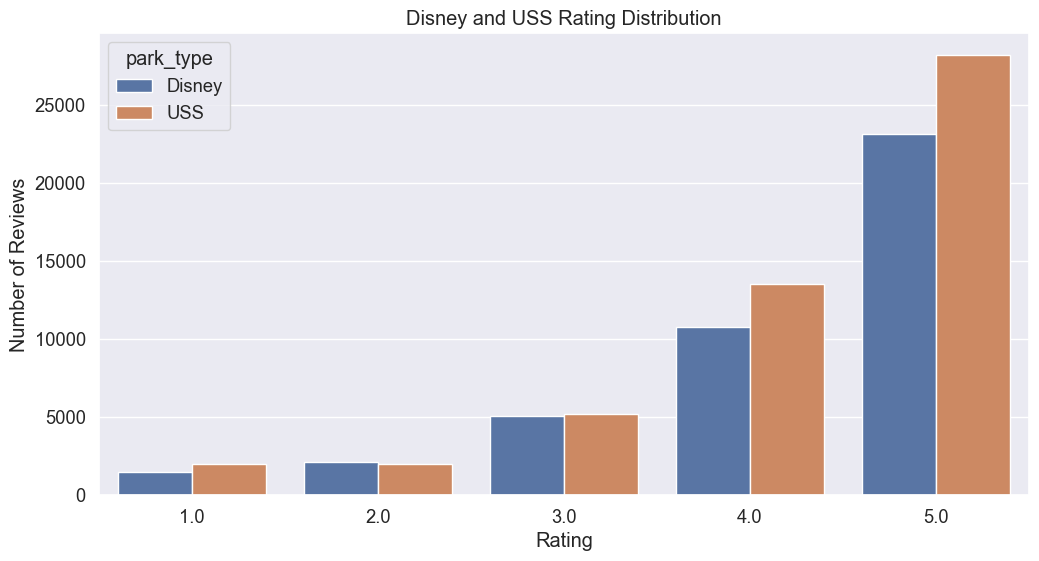

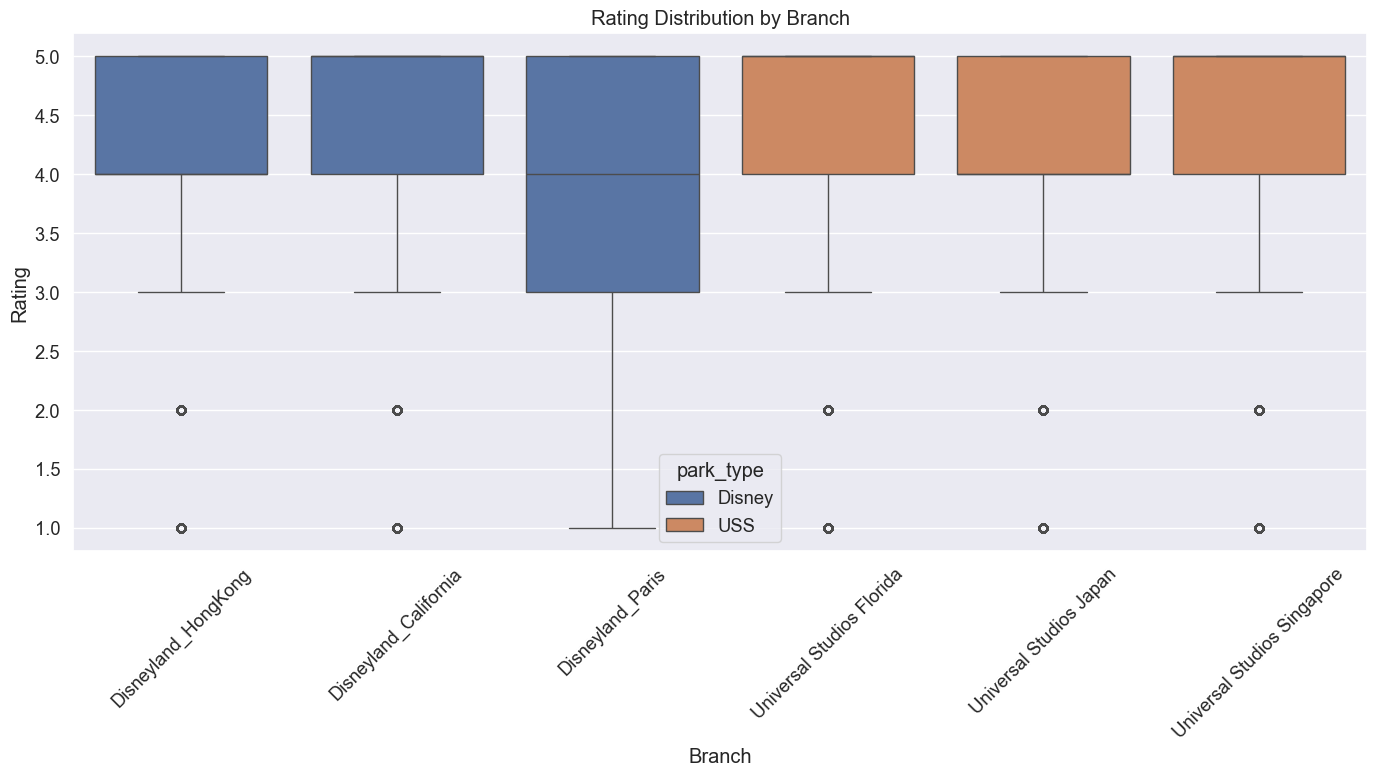

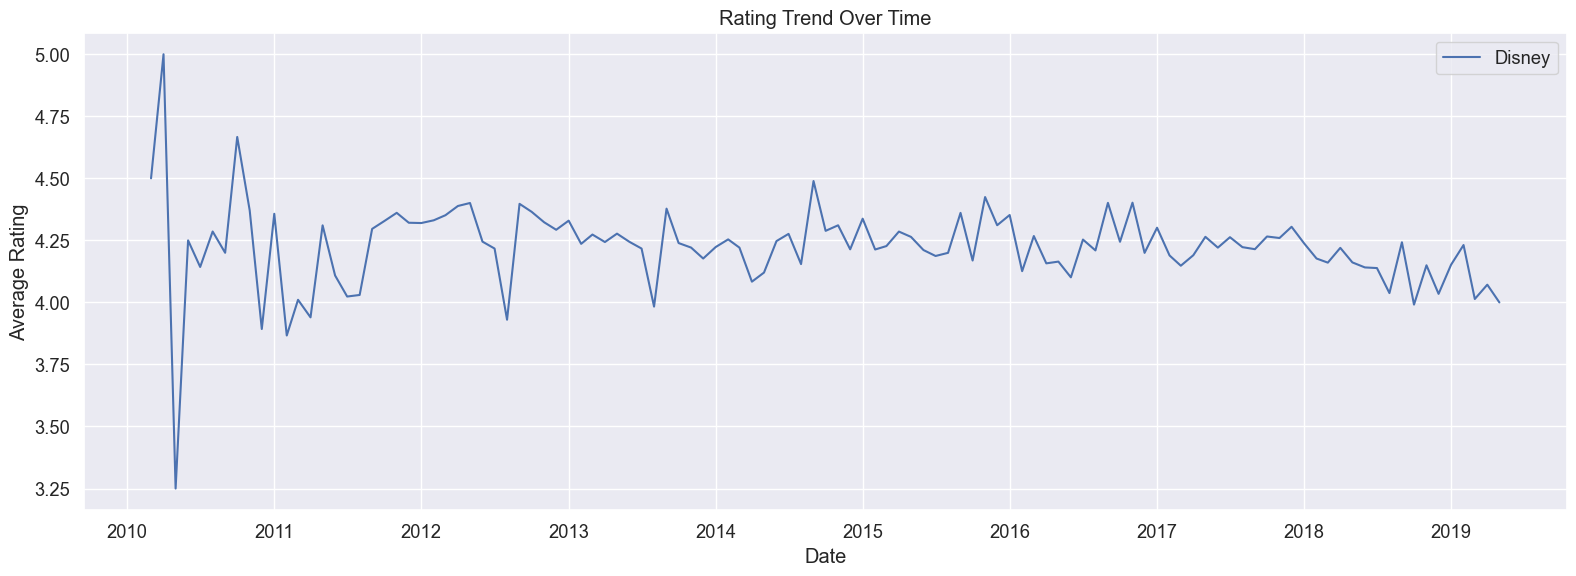

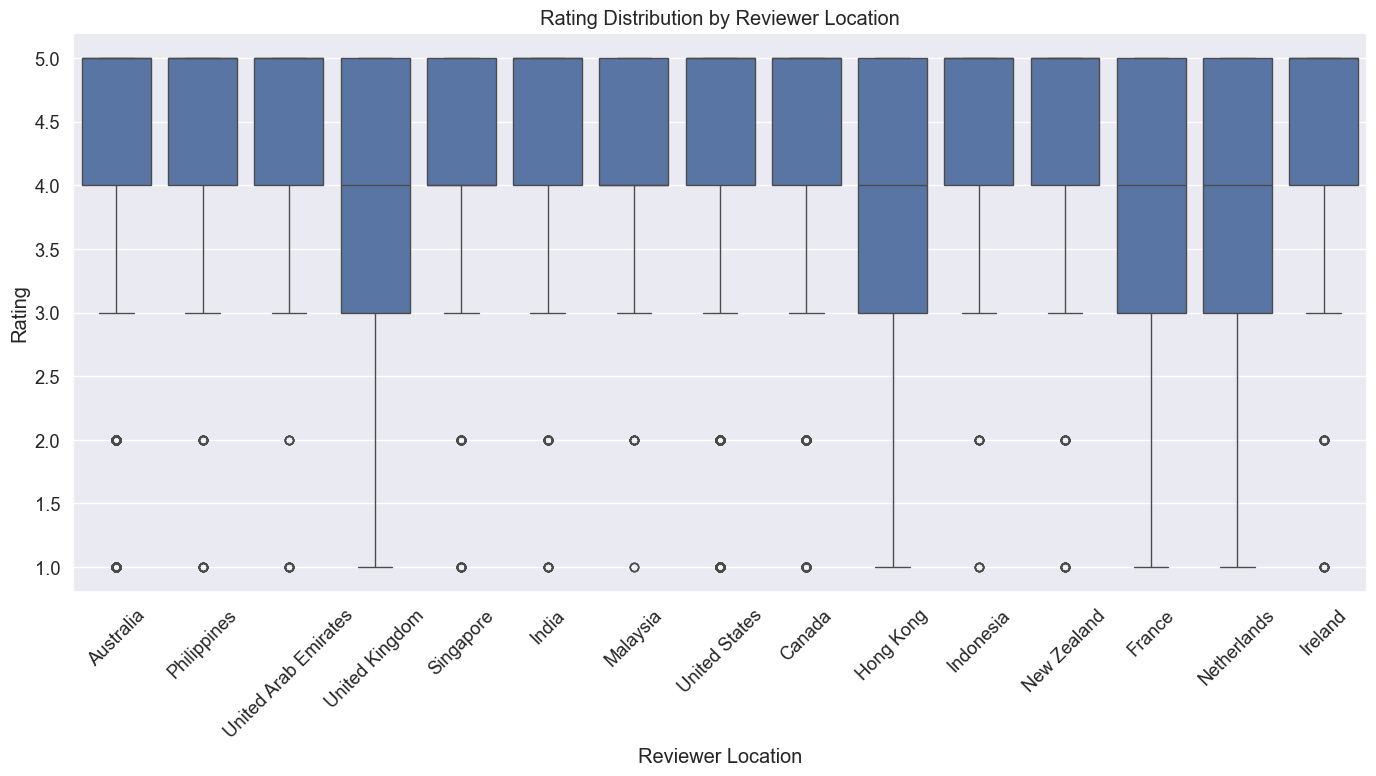

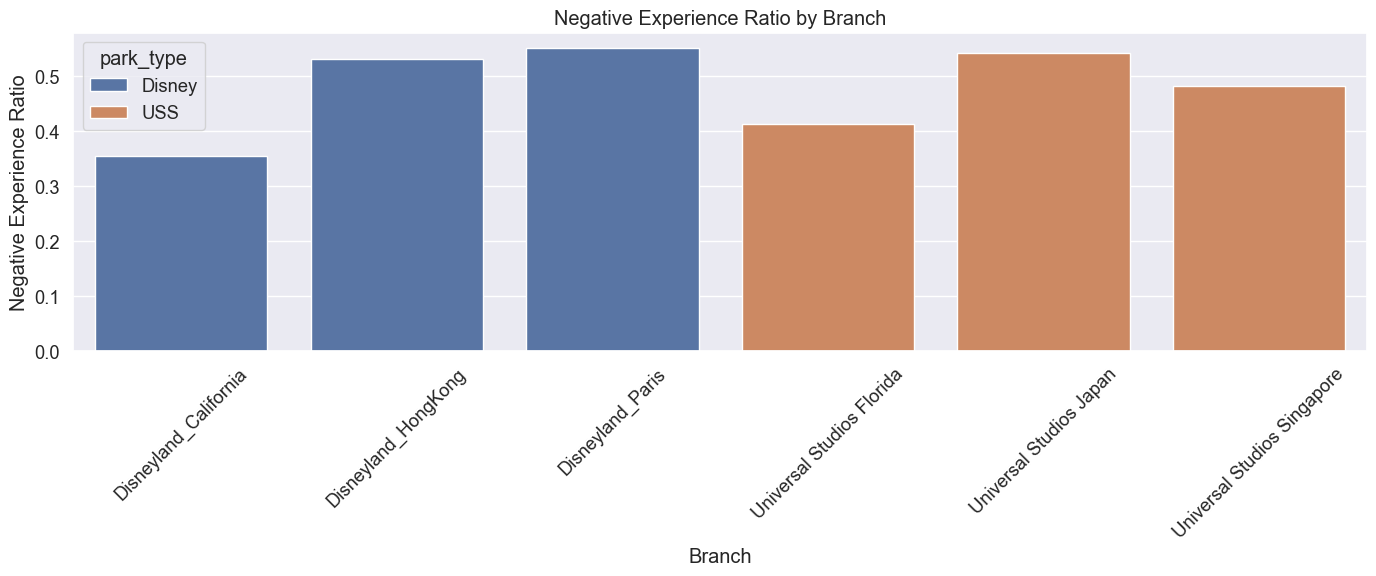

In [4]:
# Set visualization style
sns.set_style('whitegrid')  # Use the 'whitegrid' style from Seaborn
sns.set(font_scale=1.2)

# 1. Rating Distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='rating', hue='park_type', data=combined_df)
plt.title('Disney and USS Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.savefig('rating_distribution.png')
plt.show()

# 2. Rating Distribution by Branch
plt.figure(figsize=(14, 8))
sns.boxplot(x='branch', y='rating', hue='park_type', data=combined_df)
plt.title('Rating Distribution by Branch')
plt.xlabel('Branch')
plt.ylabel('Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('branch_ratings.png')
plt.show()

# 3. Rating Trend Over Time
monthly_ratings = combined_df.groupby(['year', 'month', 'park_type'])['rating'].mean().reset_index()
monthly_ratings['date'] = pd.to_datetime(monthly_ratings[['year', 'month']].assign(day=1))

plt.figure(figsize=(16, 6))
for park in monthly_ratings['park_type'].unique():
    park_data = monthly_ratings[monthly_ratings['park_type'] == park]
    plt.plot(park_data['date'], park_data['rating'], label=park)
plt.title('Rating Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.legend()
plt.tight_layout()
plt.savefig('rating_trend.png')
plt.show()

# 4. Rating Distribution by Reviewer Location
top_locations = combined_df['reviewer_location'].value_counts().head(15).index
location_df = combined_df[combined_df['reviewer_location'].isin(top_locations)]

plt.figure(figsize=(14, 8))
sns.boxplot(x='reviewer_location', y='rating', data=location_df)
plt.title('Rating Distribution by Reviewer Location')
plt.xlabel('Reviewer Location')
plt.ylabel('Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('location_ratings.png')
plt.show()

# 5. Negative Experience by Branch
plt.figure(figsize=(14, 6))
bad_exp_by_branch = combined_df.groupby(['branch', 'park_type'])['bad_experience'].mean().reset_index()
sns.barplot(x='branch', y='bad_experience', hue='park_type', data=bad_exp_by_branch)
plt.title('Negative Experience Ratio by Branch')
plt.xlabel('Branch')
plt.ylabel('Negative Experience Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('bad_experience_by_branch.png')
plt.show()

In [5]:
# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# 1. Sentiment Analysis
combined_df['sentiment_score'] = combined_df['review_text'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
combined_df['sentiment_negative'] = combined_df['review_text'].apply(lambda x: sia.polarity_scores(str(x))['neg'])
combined_df['sentiment_positive'] = combined_df['review_text'].apply(lambda x: sia.polarity_scores(str(x))['pos'])

# 2. Keyword Extraction
negative_reviews = combined_df[combined_df['bad_experience'] == 1]['review_text']
positive_reviews = combined_df[combined_df['bad_experience'] == 0]['review_text']

tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_neg = tfidf.fit_transform(negative_reviews)
tfidf_pos = tfidf.transform(positive_reviews)

feature_names = tfidf.get_feature_names_out()
neg_tfidf_means = tfidf_neg.mean(axis=0).A1
pos_tfidf_means = tfidf_pos.mean(axis=0).A1
diff_means = neg_tfidf_means - pos_tfidf_means

top_diff_indices = diff_means.argsort()[-100:][::-1]
top_neg_words = [feature_names[i] for i in top_diff_indices]

logging.info("\nTop 20 words most distinguishing in negative reviews:")
logging.info(top_neg_words[:20])

2025-03-24 01:57:19,557 - INFO - 
Top 20 words most distinguishing in negative reviews:
2025-03-24 01:57:19,557 - INFO - ['people', 'closed', 'line', 'good', 'disney', 'long', 'hour', 'hours', 'money', 'queue', 'park', 'expensive', 'minutes', 'disappointed', 'small', 'waiting', 'food', 'queues', 'tickets', 'rides']


In [ ]:
def get_bert_embeddings(texts, batch_size=32):
    """
    Generate BERT embeddings for a list of texts.
    """
    # Ensure texts is a list of strings
    if isinstance(texts, pd.Series):
        texts = texts.astype(str).tolist()
    elif not isinstance(texts, list):
        raise ValueError("Input must be a list of strings or a pandas Series.")

    # Load pre-trained BERT model and tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    model.to(device)
    model.eval()

    # Store the embedding vectors
    embeddings = []

    # Process in batches
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]

        # Tokenize and convert to tensor
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Get BERT embeddings
        with torch.no_grad():
            outputs = model(**inputs)

        # Use the embedding of the [CLS] token
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

# Create a sample of the combined DataFrame
sample_size = max(1000, int(len(combined_df) * 0.1))  # Use 10% of the data or 1000 samples, whichever is larger
sample_df = combined_df.sample(sample_size, random_state=42)

# Ensure the 'review_text' column is clean
sample_df['review_text'] = sample_df['review_text'].fillna('')  # Fill missing values with empty strings

# Generate BERT embeddings
bert_embeddings = get_bert_embeddings(sample_df['review_text'])

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
bert_2d = pca.fit_transform(bert_embeddings)

# Plot BERT embeddings
plt.figure(figsize=(10, 8))
scatter = plt.scatter(bert_2d[:, 0], bert_2d[:, 1], c=sample_df['bad_experience'].values, cmap='coolwarm', alpha=0.6)
plt.colorbar(scatter, label='Negative Experience')
plt.title('Visualization of BERT Embeddings')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.savefig('bert_embeddings.png')
plt.show()

  7%|██▊                                       | 20/293 [02:00<31:34,  6.94s/it]

In [ ]:
# Perform topic modeling using LDA
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = cv.fit_transform(combined_df['review_text'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

logging.info("\nMain topics in reviews:")
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-11:-1]
    top_words = [cv.get_feature_names_out()[i] for i in top_words_idx]
    logging.info(f"Topic {topic_idx+1}: {', '.join(top_words)}")

topic_results = lda.transform(dtm)
combined_df['dominant_topic'] = topic_results.argmax(axis=1)

topic_bad_exp = combined_df.groupby('dominant_topic')['bad_experience'].mean().reset_index()
logging.info("\nNegative experience ratio of each topic:")
logging.info(topic_bad_exp)

plt.figure(figsize=(10, 6))
sns.barplot(x='dominant_topic', y='bad_experience', data=topic_bad_exp)
plt.title('Negative Experience Ratio by Topic')
plt.xlabel('Topic Number')
plt.ylabel('Negative Experience Ratio')
plt.savefig('topic_bad_experience.png')
plt.show()

In [ ]:
# Prepare features and target variable
numeric_features = ['review_length', 'word_count', 'sentiment_score', 'sentiment_negative', 'sentiment_positive']
categorical_features = ['branch', 'park_type', 'dominant_topic']
keyword_features = [f'contains_{word}' for word in top_neg_words[:20]]

all_features = numeric_features + categorical_features + keyword_features
X = combined_df[all_features].copy()
y = combined_df['bad_experience']

# Handle missing values
num_imputer = SimpleImputer(strategy='median')
X[numeric_features] = num_imputer.fit_transform(X[numeric_features])
cat_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_features + keyword_features] = cat_imputer.fit_transform(X[categorical_features + keyword_features])

# Split training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocess pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create model pipeline
models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
    ]),
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ])
}

# Train and evaluate models
results = {}
for name, model in models.items():
    logging.info(f"\nTraining {name} model...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    logging.info(f"{name} model evaluation results:")
    logging.info(classification_report(y_test, y_pred))
    logging.info(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
    results[name] = {
        'model': model,
        'accuracy': (y_pred == y_test).mean(),
        'roc_auc': roc_auc_score(y_test, y_prob)
    }

# Find the best model
best_model_name = max(results, key=lambda k: results[k]['roc_auc'])
logging.info(f"\nBest model: {best_model_name}")
logging.info(f"ROC AUC: {results[best_model_name]['roc_auc']:.4f}")